In [99]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

from tqdm import tqdm
from sklearn import datasets

In [100]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [101]:
from sklearn import tree

In [102]:
from nflib import coupling_flows as cf
from nflib import flows as nf
from nflib import res_flow as rf

## 2D regression dataset

In [103]:
num_points = 100
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

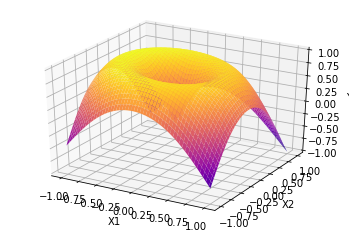

In [104]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## Linear - Split data to Maximize Information Gain

In [105]:
# class LeafNode(nn.Module):
    
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.constant = nn.Parameter(torch.zeros(output_dim)+torch.randn(output_dim)*0.1)
        
#     def forward(self, x):
#         return self.constant.expand(x.shape[0], self.constant.shape[0])
    
    
class LeafNode(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.linear.weight.data *= 0.001
        
    def forward(self, x):
        return self.linear(x)
    
    
class DecisionNode(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, 1)
#         self.linear.weight.data *= 0
        self.hardness = 1.0
        self.node0, self.node1 = None, None
        
    def forward(self, x):
        norms = torch.norm(self.linear.weight.data, dim=1, keepdim=True)
        self.linear.weight.data /= norms 

        mask = torch.sigmoid(self.linear(x)*(2**self.hardness))
        out0 = self.node0(x)
        out1 = self.node1(x)
        return out0*mask + out1*(1-mask)
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim)
            self.node1 = DecisionNode(self.input_dim, self.output_dim)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self.input_dim, self.output_dim)
            self.node1 = LeafNode(self.input_dim, self.output_dim)
            
    def set_hardness(self, hardness):
        self.hardness = hardness
#         with torch.no_grad():
#             self.hardness = hardness
#             norms = torch.norm(self.linear.weight.data, dim=1, keepdim=True)
#             factor = hardness/norms
#             self.linear.weight.data *= factor 
#             self.linear.bias.data *= factor.reshape(-1)
        if isinstance(self.node0, DecisionNode):
            self.node0.set_hardness(hardness)
        if isinstance(self.node1, DecisionNode):
            self.node1.set_hardness(hardness)
        return

In [301]:
class InvexMLP_Generator(cf.FuncGenerator):
    
    def __init__(self, hidden_dims=[], activation=nn.LeakyReLU(0.2)):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.activation = activation
        
    def generate(self, input_dim, output_dim):
        pass
    
    
class MLP_Generator(cf.FuncGenerator):

    def __init__(self, hidden_dims=[], activation=nn.LeakyReLU(0.2)):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.activation = activation

    def generate(self, input_dim, output_dim):
        dims = [input_dim, *self.hidden_dims]
        layers = []
        for i in range(len(dims)-1):
            a = nn.utils.spectral_norm(nn.Linear(dims[i], dims[i+1]))
            b = self.activation
            layers += [a, b]
        fl = nn.utils.spectral_norm(nn.Linear(dims[-1], output_dim))
#         fl.weight.data *= 0.
        layers.append(fl)
        return nn.Sequential(*layers)


class DecisionNode(nn.Module):
    
    def __init__(self, input_dim, output_dim, split_func:cf.FuncGenerator()):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
#         self.linear = nn.Linear(input_dim, 1)
        self.linear = split_func.generate(input_dim, output_dim)

#         self.linear.weight.data *= 0
        self.hardness = 0
        self.node0, self.node1 = None, None
        
    def forward(self, x):
#         norms = torch.norm(self.linear.weight.data, dim=1, keepdim=True)
#         self.linear.weight.data /= norms 
        mask = self.linear(x)
#         self.push_loss = torch.exp(-((mask-0.5)*8)**2).mean()
        ## to minimize the points on the decision boundary:
        ## push the outputs such that gradient around 0 is high
        
        mask_ = torch.sigmoid(mask)
        self.push_loss = torch.exp(-((mask-0.5)*4)**2).mean()*0.1
#         self.push_loss = -0.5*torch.mean(torch.log(mask_)+torch.log(1-mask_))*0.1
        mask = mask*(2**self.hardness)
        mask = torch.sigmoid(mask)
        
        out0 = self.node0(x)
        out1 = self.node1(x)
        return out0*mask + out1*(1-mask)
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim)
            self.node1 = DecisionNode(self.input_dim, self.output_dim)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self.input_dim, self.output_dim)
            self.node1 = LeafNode(self.input_dim, self.output_dim)
            
    def set_hardness(self, hardness):
        self.hardness = hardness
#         with torch.no_grad():
#             self.hardness = hardness
#             norms = torch.norm(self.linear.weight.data, dim=1, keepdim=True)
#             factor = hardness/norms
#             self.linear.weight.data *= factor 
#             self.linear.bias.data *= factor.reshape(-1)
        if isinstance(self.node0, DecisionNode):
            self.node0.set_hardness(hardness)
        if isinstance(self.node1, DecisionNode):
            self.node1.set_hardness(hardness)
        return

In [302]:
# mlpgen = MLP_Generator([10], nn.ELU())
mlpgen = cf.MLP_Generator([10], nn.ELU())

In [303]:
model = DecisionNode(2, 1, mlpgen)
model.create_child(1)

In [304]:
yout = model(xx)

In [305]:
model

DecisionNode(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (node0): LeafNode(
    (linear): Linear(in_features=2, out_features=1, bias=True)
  )
  (node1): LeafNode(
    (linear): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [306]:
model.linear[0].weight

Parameter containing:
tensor([[ 0.3271,  0.3662],
        [-0.0213, -0.6745],
        [ 0.5455,  0.6076],
        [ 0.5168,  0.5119],
        [-0.3560,  0.3330],
        [ 0.4513,  0.2814],
        [-0.1204,  0.1650],
        [-0.5599,  0.5853],
        [-0.1190, -0.0773],
        [ 0.3712,  0.0449]], requires_grad=True)

In [307]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3271,  0.3662],
         [-0.0213, -0.6745],
         [ 0.5455,  0.6076],
         [ 0.5168,  0.5119],
         [-0.3560,  0.3330],
         [ 0.4513,  0.2814],
         [-0.1204,  0.1650],
         [-0.5599,  0.5853],
         [-0.1190, -0.0773],
         [ 0.3712,  0.0449]], requires_grad=True), Parameter containing:
 tensor([-0.1592,  0.0171, -0.0498,  0.4899,  0.3013,  0.0393, -0.0005,  0.3076,
          0.2959, -0.2838], requires_grad=True), Parameter containing:
 tensor([[-0., -0., -0., -0., 0., -0., -0., 0., -0., -0.]], requires_grad=True), Parameter containing:
 tensor([-0.1482], requires_grad=True), Parameter containing:
 tensor([[0.0003, 0.0003]], requires_grad=True), Parameter containing:
 tensor([-0.1152], requires_grad=True), Parameter containing:
 tensor([[-0.0005, -0.0006]], requires_grad=True), Parameter containing:
 tensor([0.5726], requires_grad=True)]

In [308]:
yout.shape

torch.Size([10000, 1])

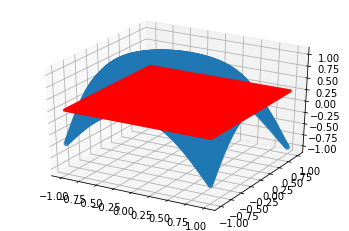

In [309]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.pause(0.1)
plt.show()

In [310]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [311]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

hardness = 0
model.set_hardness(hardness)
for epoch in range(10000):

    yout = model(xx)
    loss = criterion(yout, yy) + model.push_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%1000 == 0:
        hardness += 1
        model.set_hardness(hardness)
    
    if epoch%200 == 0:
#         fig = plt.figure(figsize=(9,8))
#         ax = fig.gca(projection='3d')

        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        yout_ = yout.data.reshape(Y.shape)
        ax.scatter(X1, X2, yout_, color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
#         plt.show()

Epoch:0 | Error:0.22596055269241333
Epoch:200 | Error:0.050110701471567154
Epoch:400 | Error:0.04855867102742195
Epoch:600 | Error:0.0478135421872139
Epoch:800 | Error:0.035421714186668396
Epoch:1000 | Error:0.07202447205781937
Epoch:1200 | Error:0.035683371126651764
Epoch:1400 | Error:0.03546636551618576
Epoch:1600 | Error:0.035216446965932846
Epoch:1800 | Error:0.02398046664893627
Epoch:2000 | Error:0.05696674808859825
Epoch:2200 | Error:0.022595901042222977
Epoch:2400 | Error:0.02216435968875885
Epoch:2600 | Error:0.021971380338072777
Epoch:2800 | Error:0.021904245018959045
Epoch:3000 | Error:0.05160623788833618
Epoch:3200 | Error:0.020967328920960426
Epoch:3400 | Error:0.02076748199760914
Epoch:3600 | Error:0.020693548023700714


TclError: invalid command name "."

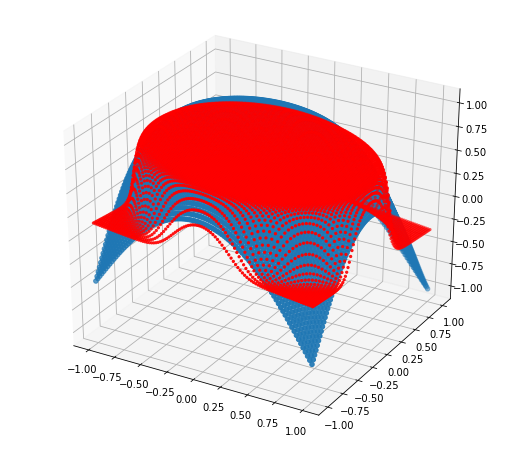

In [199]:
%matplotlib inline
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.show()

In [289]:
torch.sigmoid(model.linear(xx)).data.tolist()

[[0.48298776149749756],
 [0.4833740293979645],
 [0.483758807182312],
 [0.4841420352458954],
 [0.4845232367515564],
 [0.4849022924900055],
 [0.48527875542640686],
 [0.48565247654914856],
 [0.48602303862571716],
 [0.4863901734352112],
 [0.48675352334976196],
 [0.4871126711368561],
 [0.48746734857559204],
 [0.48781701922416687],
 [0.48816144466400146],
 [0.4884999990463257],
 [0.4888324439525604],
 [0.48915818333625793],
 [0.48947665095329285],
 [0.4897874891757965],
 [0.49009019136428833],
 [0.49038419127464294],
 [0.49066871404647827],
 [0.4909434914588928],
 [0.49120768904685974],
 [0.4914607107639313],
 [0.49170181155204773],
 [0.4919304847717285],
 [0.4921455383300781],
 [0.4923468828201294],
 [0.49253326654434204],
 [0.4927040636539459],
 [0.49285829067230225],
 [0.49299508333206177],
 [0.4931134879589081],
 [0.4932126998901367],
 [0.4932915270328522],
 [0.4933491051197052],
 [0.4933840334415436],
 [0.49339550733566284],
 [0.49338215589523315],
 [0.4933430552482605],
 [0.49327632784

### Tree with Distance Transform

In [73]:
dt = DistanceTransform(2, num_centers=3)
# dt.centers.data += torch.randn_like(dt.centers)*0.01
dt.centers.data = xx[np.random.permutation(len(xx))[:dt.num_centers]]


tensor([[-0.2525, -0.5152],
        [ 0.9596,  0.4747],
        [-0.8788,  0.7778]])


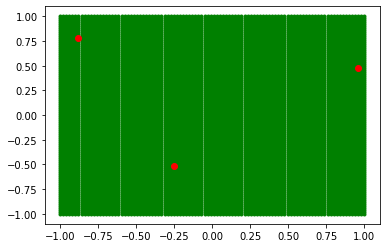

In [74]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
print(dt.centers.data)

In [75]:
xx_ = dt(xx).data
xx_

tensor([[0.8910, 2.4525, 1.7819],
        [0.8741, 2.4364, 1.7806],
        [0.8573, 2.4204, 1.7796],
        ...,
        [1.9403, 0.5253, 1.8518],
        [1.9530, 0.5256, 1.8718],
        [1.9658, 0.5268, 1.8919]])

In [76]:
dtr_ = tree.DecisionTreeRegressor(max_depth=4)

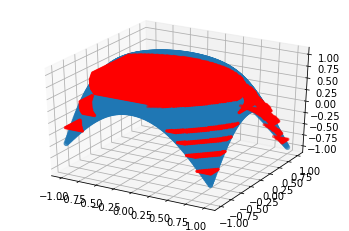

In [77]:
dtr_.fit(xx_.data.numpy(), yy.data.numpy())
yout_ = dtr_.predict(xx_.data.numpy())

%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout_.reshape(-1), color='r', marker='.')
plt.pause(0.1)
plt.show()

In [78]:
mse = ((yout_-yy.data.numpy())**2).mean()
print(mse)

0.2551496235610955


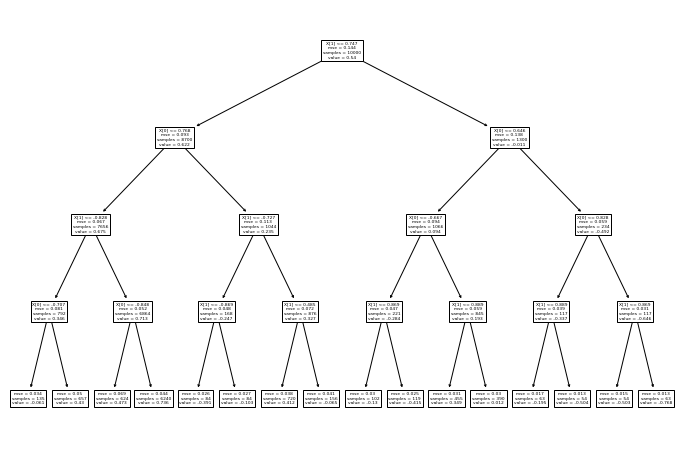

In [79]:
%matplotlib inline
plt.figure(figsize=(12,8))
tree.plot_tree(dtr)
plt.savefig("./models/tree_2d_reg_dist.svg")

# Classification Dataset 2D

In [27]:
def twospirals(n_points, noise=.5 , ang=720):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * ang * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

np.random.seed(987)
# x, y = twospirals(200, ang=420)
# x, y = twospirals(200, ang=400)
x, y = datasets.make_blobs(n_samples=200, centers=3, cluster_std=0.60, random_state=0)
x, Y = x/10, y.reshape(-1)
X1, X2 = x[:,0], x[:,1]

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

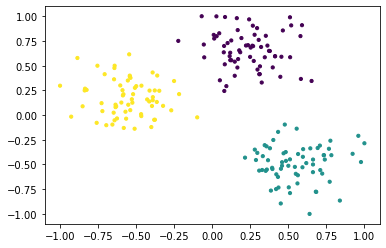

In [28]:
%matplotlib inline
fig = plt.figure()
plt.scatter(X1, X2, c=Y, s=10)
plt.show()

In [29]:
num_points = 50
_X1 = np.linspace(-2.5, 2.5, num_points)
_X2 = np.linspace(-2.5, 3, num_points)
_X1, _X2 = np.meshgrid(X1, X2)
xgrid = np.c_[_X1.reshape(-1,1), _X2.reshape(-1,1)]

In [30]:
xgrid.shape

(40000, 2)

## Ordinary Decision Tree

In [43]:
dtr = tree.DecisionTreeClassifier(max_depth=2)

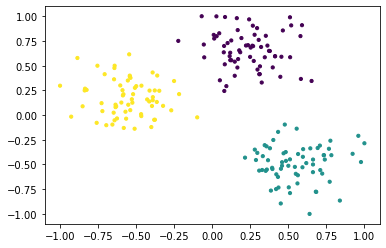

In [44]:
dtr.fit(xx.data.numpy(), yy.data.numpy())
yout = dtr.predict(xx.data.numpy())

%matplotlib inline
plt.scatter(X1, X2, c=yout, s=10)
plt.show()

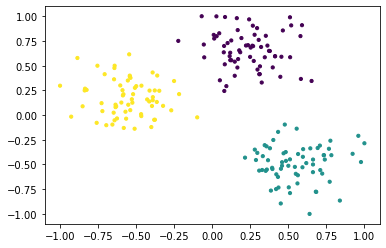

In [45]:
%matplotlib inline

plt.scatter(X1, X2, c=yout, s=10)
plt.show()

In [46]:
yout.shape

(200,)

In [40]:
acc = yout.reshape(-1,1)==yy.data.numpy()
acc = np.count_nonzero(acc)/len(acc)
print(acc)

1.0


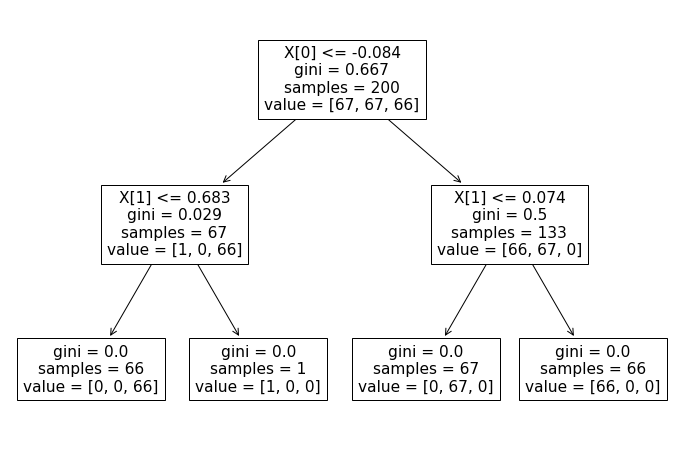

In [35]:
%matplotlib inline
plt.figure(figsize=(12,8))
tree.plot_tree(dtr)
plt.savefig("./models/tree_2d_cls_ord.svg")

### Decision tree with distance transform

In [36]:
dt = DistanceTransform(2, num_centers=3)
# dt.centers.data += torch.randn_like(dt.centers)*0.01
dt.centers.data = xx[np.random.permutation(len(xx))[:dt.num_centers]]

NameError: name 'DistanceTransform' is not defined

tensor([[-0.9180,  0.0757],
        [ 0.0847,  0.8992],
        [ 0.2251,  0.3768]])


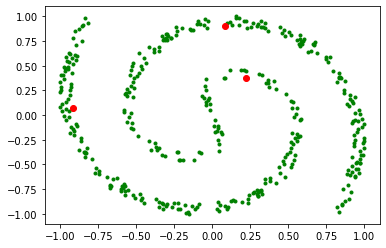

In [146]:
%matplotlib inline
fig = plt.figure()
plt.scatter(xx[:,0], xx[:,1], c='g', marker='.')
plt.scatter(dt.centers.data[:,0], dt.centers.data[:,1], c='r', marker='o')
print(dt.centers.data)

In [147]:
xx_ = dt(xx).data
xx_

tensor([[1.5086, 1.7996, 1.2707],
        [1.5156, 1.7353, 1.2016],
        [0.2945, 1.1862, 1.1994],
        ...,
        [0.4475, 0.8688, 0.7479],
        [1.8459, 1.2758, 0.8246],
        [0.9564, 1.2881, 0.8134]])

In [148]:
xx_.shape, yy.shape

(torch.Size([400, 3]), torch.Size([400, 1]))

In [149]:
dtr_ = tree.DecisionTreeClassifier(max_depth=4)

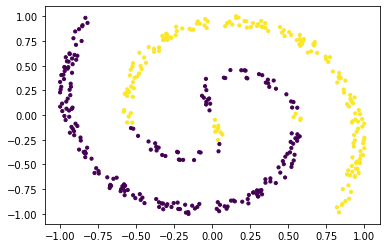

In [150]:
dtr_.fit(xx_.data.numpy(), yy.data.numpy())
yout_ = dtr_.predict(xx_.data.numpy())#.reshape(-1,1)

%matplotlib inline
plt.scatter(X1, X2, c=yout_, s=10)
plt.show()

In [151]:
yout_.shape

(400,)

In [152]:
acc = yout_.reshape(-1,1)==yy.data.numpy()
acc = np.count_nonzero(acc)/len(acc)
print(acc)

0.9375


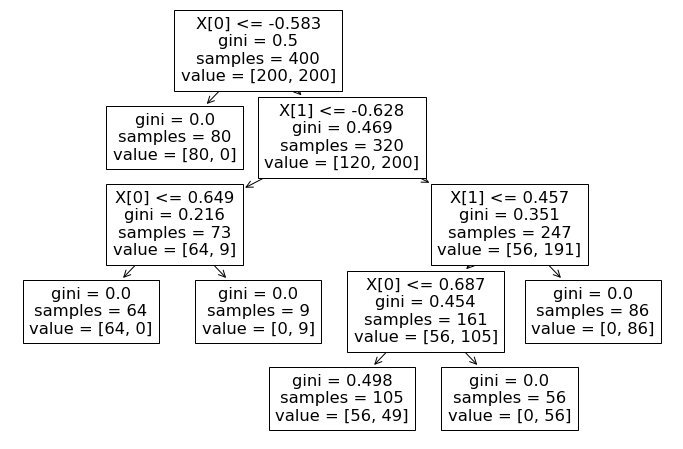

In [153]:
%matplotlib inline
plt.figure(figsize=(12,8))
tree.plot_tree(dtr)
plt.savefig("./models/tree_2d_cls_dist.svg")